# Imports and setup

In [1]:
from torch import nn, optim
import torch

from torch.utils.data import DataLoader
from torchvision import models
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time


c:\Users\Arthur\Documents\Github\Face-Swap-M2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
import dataloader

### Check si on peut utiliser cuda

In [3]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


### classe pour mesurer le temps d'entrainement restant

In [15]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))


# Chargement du dataset

In [4]:
IMAGE_SIZE = 128
NB_IMAGES = 10

In [5]:
train_dataset, test_dataset, nb_classes = dataloader.make_dataset("../data/Face-Swap-M2-Dataset/dataset/smaller", NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=False)


Building dataset 



# Paramètres

In [7]:

EMBEDDING_SIZE = 128
BATCH_SIZE = 32

EPOCHS = 100

In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Min pixel value:", images.min().item())
    print("Max pixel value:", images.max().item())
    print("Mean pixel value:", images.mean().item())
    break

Batch shape: torch.Size([32, 3, 128, 128])
Min pixel value: -0.9764705896377563
Max pixel value: 1.0
Mean pixel value: 0.07839137315750122


train samples: 67, test samples: 20, nb_classes: 10
train Class 0: 8 samples
train Class 1: 7 samples
train Class 2: 7 samples
train Class 3: 5 samples
train Class 4: 4 samples
train Class 5: 7 samples
train Class 6: 8 samples
train Class 7: 7 samples
train Class 8: 8 samples
train Class 9: 6 samples
Test Class 0: 2 samples
Test Class 1: 2 samples
Test Class 2: 2 samples
Test Class 3: 2 samples
Test Class 4: 2 samples
Test Class 5: 2 samples
Test Class 6: 2 samples
Test Class 7: 2 samples
Test Class 8: 2 samples
Test Class 9: 2 samples


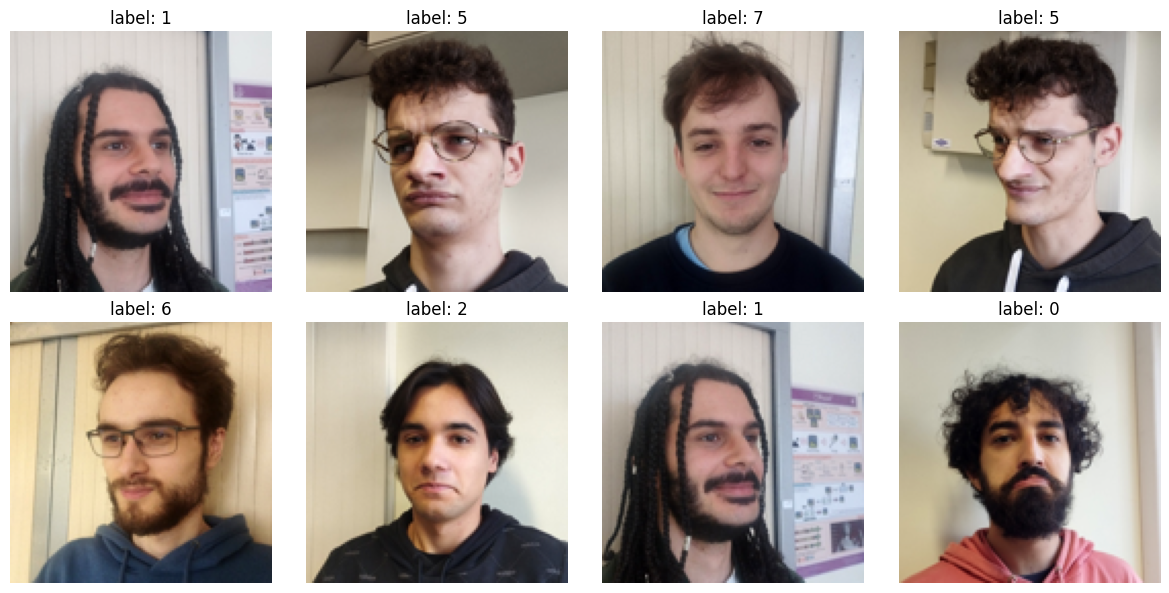

In [10]:
print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

class_counts = np.bincount([label for _, label in train_dataset])
for cls, count in enumerate(class_counts):
    print(f"train Class {cls}: {count} samples")

class_counts = np.bincount([label for _, label in test_dataset])
for cls, count in enumerate(class_counts):
    print(f"Test Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Définition des modèles

In [12]:


class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), # 3 car image RGB, 6 en sortie (6 filtres) , taille noyau de 5
            nn.BatchNorm2d(8), # empeche le collapse des embeddings
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # reduit par 2 la taille
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Linear(16 *32*32, EMBEDDING_SIZE )

    def forward(self,x):
        res = self.conv(x)
        res = torch.flatten(res,1)
        res = self.fc(res)
        res = res / res.norm(dim= 1, keepdim=True).clamp(min=1e-6) # normalise la sortie, donne de meilleur resultat
        return res


class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(EMBEDDING_SIZE, num_classes)
    def forward(self, x):
        return self.fc(x)
    

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(EMBEDDING_SIZE, 128, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),

        )

    def forward(self, x):
        res = x.unflatten(1, (EMBEDDING_SIZE, 1, 1))
        res = self.decoder(res)
        return res




# Embedding

## Entrainement

In [ ]:
faceEmbedder = Embedder().to(device)

model_parameters = filter(lambda p: p.requires_grad, faceEmbedder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Embedder has {params} parameters")

triplet_loss = TripletMarginLoss(margin=1.0)
miner = BatchHardMiner()
optimizer = optim.Adam(faceEmbedder.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

final_embedder_loss = 0.0

train_losses = []
val_losses = []

faceEmbedder.train()
for epoch in range(200):

    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)
        #anchors = output[anchor_idx]
        #positives = output[positive_idx]
        #negatives = output[negative_idx]
        #loss = triplet_loss(anchors, positives, negatives)

        triplets = miner(output, labels)

        loss = triplet_loss(output,labels, triplets)

        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss = total_loss / len(train_loader)
    train_losses.append(total_loss)

    faceEmbedder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = faceEmbedder(images)
            #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)

            #anchors = output[anchor_idx]
            #positives = output[positive_idx]
            #negatives = output[negative_idx]
            #loss = triplet_loss(anchors, positives, negatives)

            triplets = miner(output, labels)

            loss = triplet_loss(output,labels, triplets)

            val_loss += loss.item()

    val_loss = val_loss / len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")
    final_embedder_loss = total_loss
    faceEmbedder.train()


Embedder has 2098720 parameters
Epoch 1, Training Loss: 0.4192, Validation Loss: 0.5649
Epoch 2, Training Loss: 0.3138, Validation Loss: 0.5502
Epoch 3, Training Loss: 0.2751, Validation Loss: 0.5434
Epoch 4, Training Loss: 0.2357, Validation Loss: 0.5382
Epoch 5, Training Loss: 0.1604, Validation Loss: 0.5534
Epoch 6, Training Loss: 0.1324, Validation Loss: 0.5694
Epoch 7, Training Loss: 0.0542, Validation Loss: 0.5600
Epoch 8, Training Loss: 0.0379, Validation Loss: 0.5638
Epoch 9, Training Loss: 0.0000, Validation Loss: 0.5611
Epoch 10, Training Loss: 0.0438, Validation Loss: 0.5519
Epoch 11, Training Loss: 0.0149, Validation Loss: 0.5396
Epoch 12, Training Loss: 0.0355, Validation Loss: 0.5271
Epoch 13, Training Loss: 0.0000, Validation Loss: 0.5266
Epoch 14, Training Loss: 0.0203, Validation Loss: 0.4992
Epoch 15, Training Loss: 0.0549, Validation Loss: 0.4890
Epoch 16, Training Loss: 0.0000, Validation Loss: 0.4885
Epoch 17, Training Loss: 0.0178, Validation Loss: 0.4850
Epoch 18

In [115]:
torch.save(faceEmbedder.state_dict(), f"embedder_150.pth")

## Analyse

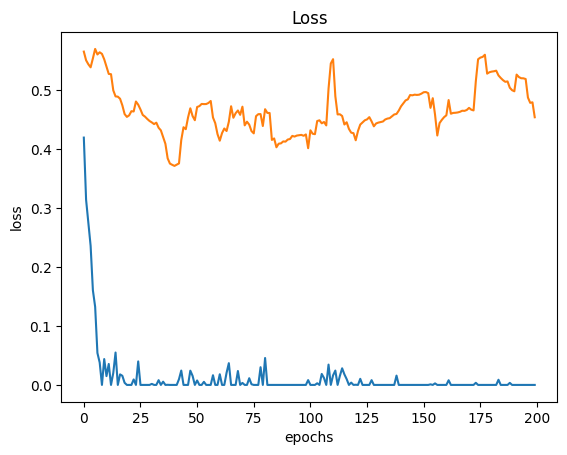

In [32]:
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Calcul tous les embeddings

In [33]:
faceEmbedder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        for i in range(output.size(0)):
            embeddings.append([output[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

classe 0: avg embedding = [0.1589801236987114, 0.10317405592650175, -0.1487905029207468, -0.11878542974591255, 0.0015986163052730262, 0.003356466495915811, 0.06098640011623502, 0.001777914738340769, -0.12306509632617235, 0.017460158094763756, -0.113201635889709, 0.039558358024805784, 0.012408066657371819, 0.045598740922287107, 0.10422625858336687, 0.0003410023055039346, -0.12193735223263502, 0.09882631804794073, 0.031052431324496865, 0.005696868029190227, 0.04467861331067979, -0.04803455853834748, 0.13777438458055258, 0.05978464335203171, 0.1278856908902526, -0.08507297188043594, -0.07487401645630598, 0.027880935522262007, -0.003976785723352805, 0.14021440781652927, 0.07442644843831658, -0.02836956677492708, -0.048127382062375546, -0.09121786244213581, -0.06284377025440335, 0.10539929661899805, -0.07873431965708733, 0.03044910915195942, 0.08588199224323034, 0.14914418756961823, 0.0034912360133603215, 0.09950755722820759, 0.16163467057049274, 0.16991190239787102, 0.06486788531765342, 0.

In [34]:
import math

faceEmbedder.eval()

correct = 0
total = 0
avg_embeddings = torch.Tensor(avg_embeddings).to(device)

with torch.no_grad():
    for images, labels in DataLoader(test_dataset, batch_size=1):
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        min_dist = math.inf
        i_min = -1
        for i in range(len(avg_embeddings)):
            d = torch.dist(output[0], avg_embeddings[i])
            if d.item() < min_dist:
                i_min = i
                min_dist = d.item()

        if i_min == labels[0].item():
            correct += 1

        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0 
print(f"accuracy: {accuracy:.4f}, {correct} / {total}")


accuracy: 0.8500, 17 / 20


### Plot embeddings

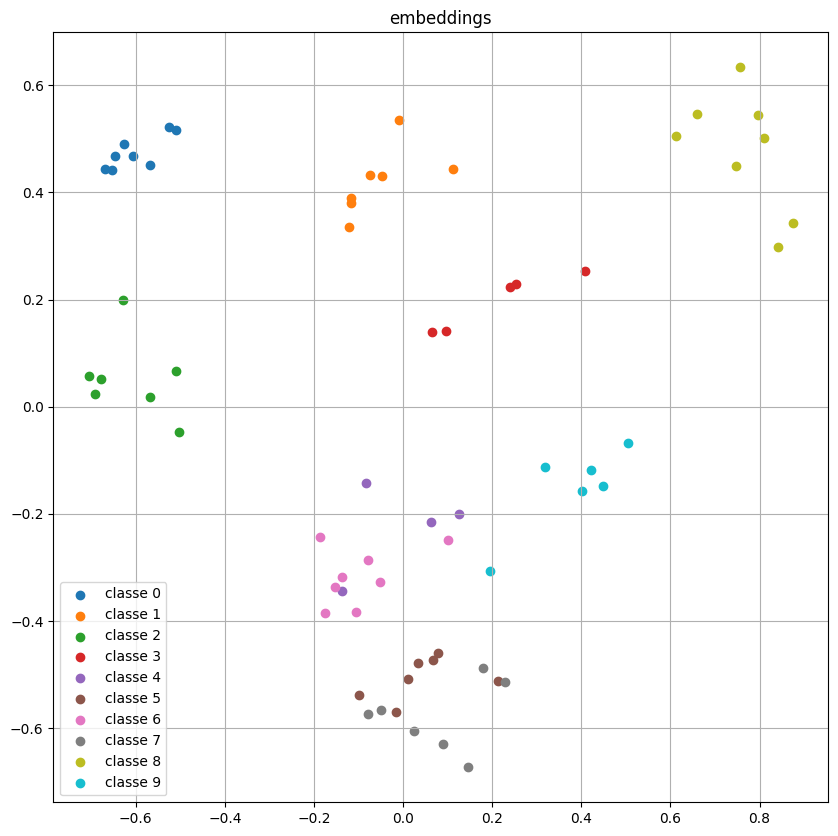

In [35]:
def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

# Classifieur

## Entrainement

In [45]:

classifier = Classifier(nb_classes).to(device)
crossLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(500):
    total_loss = 0.0
    classifier.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    classifier.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



#print("Classifier final train loss : ", final_classifier_loss[0], " test loss : ", final_classifier_loss[1])

Epoch 1, training loss: 2.3131, test loss: 2.3154
Epoch 2, training loss: 2.2878, test loss: 2.3000
Epoch 3, training loss: 2.2595, test loss: 2.2853
Epoch 4, training loss: 2.2308, test loss: 2.2711
Epoch 5, training loss: 2.2294, test loss: 2.2573
Epoch 6, training loss: 2.2063, test loss: 2.2436
Epoch 7, training loss: 2.1713, test loss: 2.2300
Epoch 8, training loss: 2.1811, test loss: 2.2166
Epoch 9, training loss: 2.1567, test loss: 2.2032
Epoch 10, training loss: 2.1426, test loss: 2.1897
Epoch 11, training loss: 2.1371, test loss: 2.1764
Epoch 12, training loss: 2.1011, test loss: 2.1633
Epoch 13, training loss: 2.0824, test loss: 2.1505
Epoch 14, training loss: 2.0782, test loss: 2.1377
Epoch 15, training loss: 2.0707, test loss: 2.1249
Epoch 16, training loss: 2.0382, test loss: 2.1121
Epoch 17, training loss: 2.0296, test loss: 2.0994
Epoch 18, training loss: 1.9970, test loss: 2.0867
Epoch 19, training loss: 1.9952, test loss: 2.0741
Epoch 20, training loss: 1.9618, test lo

## Analyse

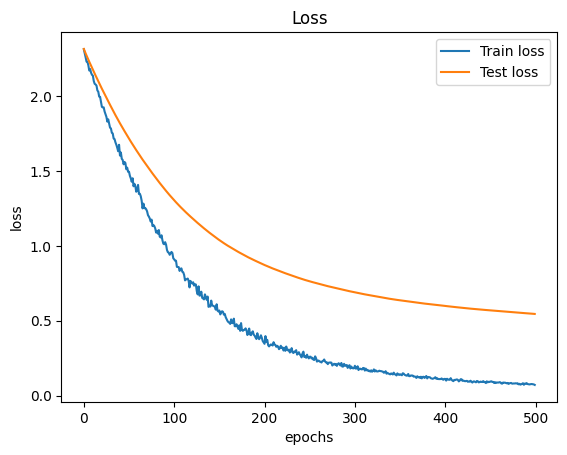

In [46]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

### Plot la matrice de confusion et accuracy

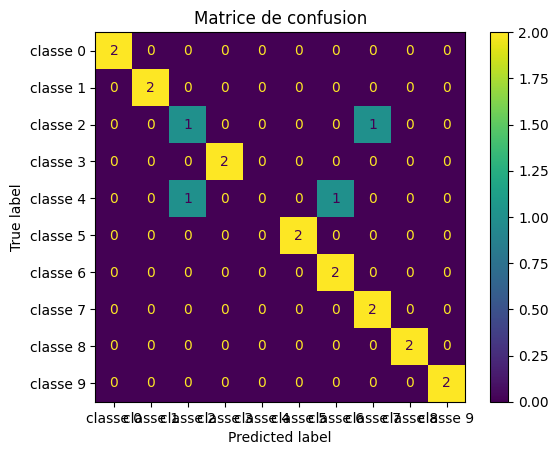

accuracy on test set: 85.00% (17/20)


In [47]:
def plot_confusion_matrix():
    classifier.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            #images = torch.flatten(images, 1)
            images = images.to(device)
            labels = labels.to(device)

            embeded = faceEmbedder(images)
            output = classifier(embeded)
            predictions = torch.argmax(output, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=range(nb_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"classe {i}" for i in range(nb_classes)])
    disp.plot()
    plt.title("Matrice de confusion")
    plt.show()

plot_confusion_matrix()


classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        #images = torch.flatten(images, 1).to(device)
        images = images.to(device)
        labels = labels.to(device)
        logits = classifier(faceEmbedder(images))
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0
print(f"accuracy on test set: {accuracy * 100:.2f}% ({correct}/{total})")

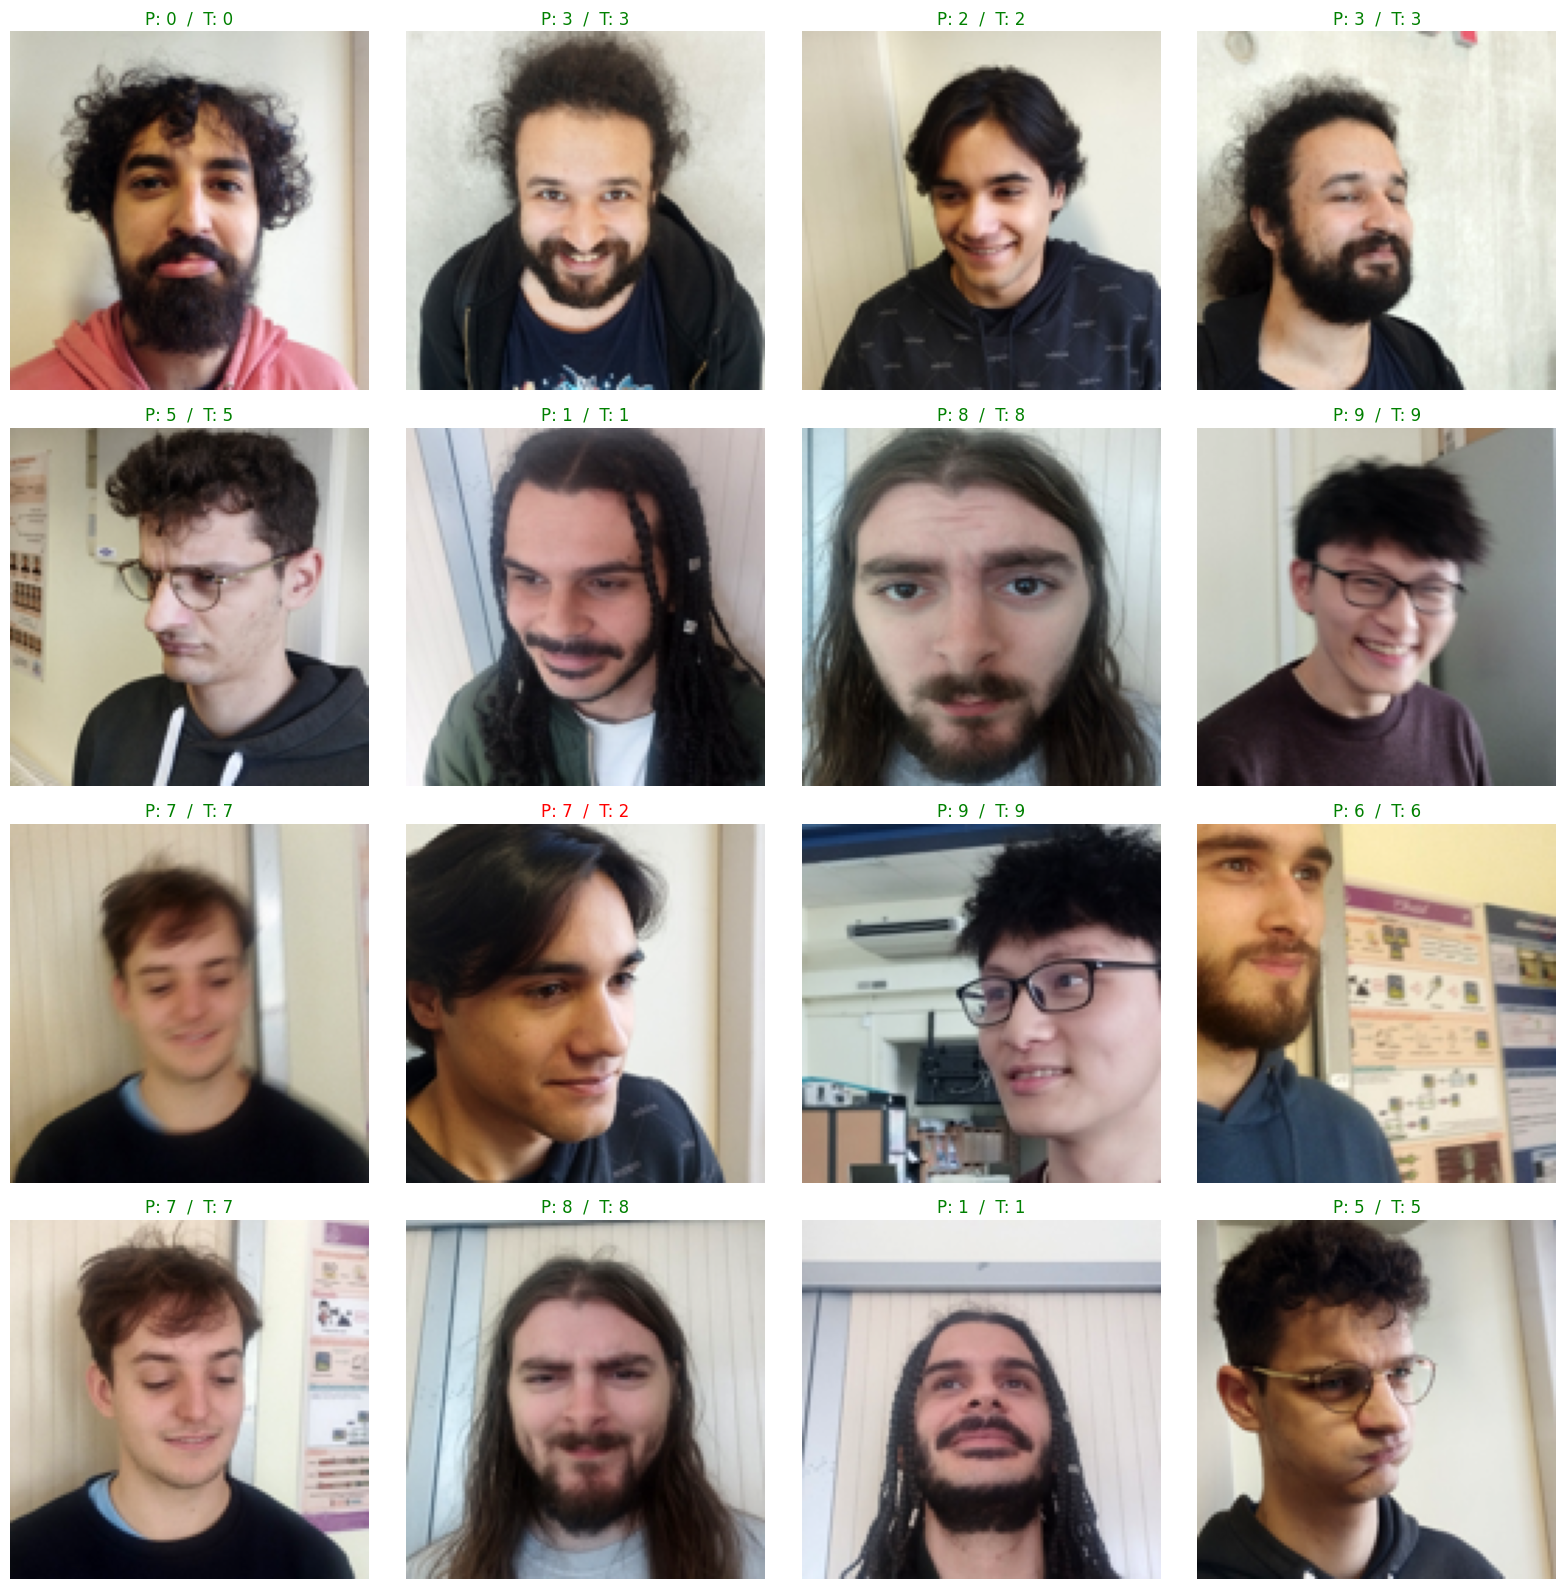

In [40]:
import math

faceEmbedder.eval()
classifier.eval()

num_display = 16 
cols = 4
rows = math.ceil(num_display / cols)

imgs_to_show = []
trues = []
preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images_cpu = images.cpu()
        images_dev = images.to(device)
        labels_dev = labels.to(device)

        embeddings = faceEmbedder(images_dev)
        logits = classifier(embeddings)
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        batch_labels = labels_dev.cpu().numpy()

        for i in range(images_cpu.size(0)):
            imgs_to_show.append(images_cpu[i].permute(1, 2, 0).numpy())
            trues.append(int(batch_labels[i]))
            preds.append(int(batch_preds[i]))
            if len(imgs_to_show) >= num_display:
                break
        if len(imgs_to_show) >= num_display:
            break

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis("off")
    if i < len(imgs_to_show):
        img = imgs_to_show[i]
        mi, ma = img.min(), img.max()
        denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
        img_disp = (img - mi) / denom
        ax.imshow(img_disp)
        true = trues[i]
        pred = preds[i]
        color = "green" if pred == true else "red"
        ax.set_title(f"P: {pred}  /  T: {true}", color=color, fontsize=12)
plt.tight_layout()
plt.show()

# VAE

In [36]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Embedder()
        self.decoder = Decoder()

    def forward(self, x):
        emb = self.encoder(x) #embedding
        im = self.decoder(emb) #reconstructed image
        return emb, im

## Entrainement autoencoder complet

In [35]:
autoencoder = AutoEncoder().to(device)

final_classifier_loss = [0.0,0.0]
losses = []

L1loss = nn.L1Loss()
lpipsLoss = lpips.LPIPS(net='alex').to(device)
lpips_factor = 0.1

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Arthur\Documents\Github\Face-Swap-M2\.venv\Lib\site-packages\lpips\weights\v0.1\alex.pth


In [ ]:

checkpoint_path = "autoencoder_epoch_300.pth"
autoencoder.load_state_dict(torch.load(checkpoint_path))
autoencoder.eval()

In [36]:
epochs = 200

eta = ETA(epochs)

for epoch in range(epochs):
    eta.update()
    eta.print()
    total_loss = 0.0
    autoencoder.train()
    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        embeddings, outputs = autoencoder(images)

        with torch.no_grad():
            lpips_loss = lpipsLoss(outputs, images).mean()
        loss = L1loss(outputs, images) + lpips_factor * (lpips_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    autoencoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        embeddings, outputs = autoencoder(images)
        with torch.no_grad():
            lpips_loss = lpipsLoss(outputs, images).mean()
        loss =  L1loss(outputs, images) + lpips_factor * (lpips_loss)

        total_eval_loss += loss.item()

    scheduler.step()

    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss

    if (epoch + 1) % 50 == 0:
        torch.save(autoencoder.state_dict(), f"models/autoencoder_epoch_{epoch+1}.pth")

0s
Epoch 1, training loss: 0.5139, test loss: 0.5327
7m 40s
Epoch 2, training loss: 0.5191, test loss: 0.5324
34s
Epoch 3, training loss: 0.5193, test loss: 0.5322
33s
Epoch 4, training loss: 0.5251, test loss: 0.5319
33s
Epoch 5, training loss: 0.5130, test loss: 0.5315
33s
Epoch 6, training loss: 0.5209, test loss: 0.5312
32s
Epoch 7, training loss: 0.5269, test loss: 0.5289
32s
Epoch 8, training loss: 0.5069, test loss: 0.5235
32s
Epoch 9, training loss: 0.4930, test loss: 0.5157
32s
Epoch 10, training loss: 0.4785, test loss: 0.5055
32s
Epoch 11, training loss: 0.4737, test loss: 0.5075
32s
Epoch 12, training loss: 0.4838, test loss: 0.4863
31s
Epoch 13, training loss: 0.4739, test loss: 0.4806
31s
Epoch 14, training loss: 0.4542, test loss: 0.4791
31s
Epoch 15, training loss: 0.4467, test loss: 0.4728
31s
Epoch 16, training loss: 0.4298, test loss: 0.4720
31s
Epoch 17, training loss: 0.4494, test loss: 0.4633
31s
Epoch 18, training loss: 0.4442, test loss: 0.4567
30s
Epoch 19, tra

### Analyse

#### Loss

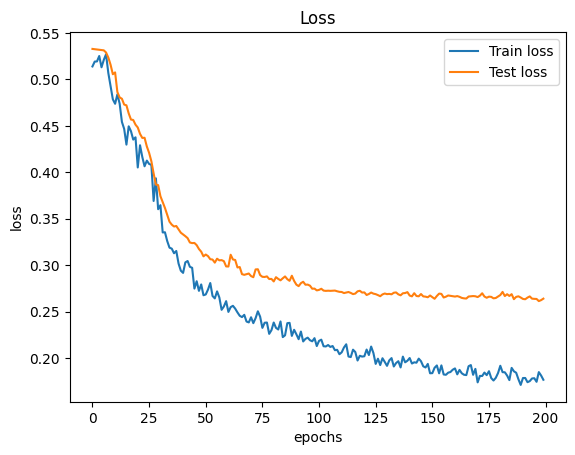

In [37]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

#### Encoder

classe 0: avg embedding = [0.033845140831544995, -0.09697482839692384, 0.06382471893448383, 0.023896152386441827, 0.11199819250032306, 0.007976495151524432, 0.11261767242103815, -0.01683302951278165, -0.14076825487427413, -0.007381156086921692, -0.04340125931776129, -0.06763189274352044, -0.07276969304075465, 0.06746141111943871, -0.06575483112828806, -0.07826084783300757, 0.10527026455383748, 0.011490031145513058, -0.04278730130317854, -0.06573531834874302, -0.11870936304330826, 0.08730372320860624, 0.09016877925023437, 0.012810336222173646, -0.1092132730409503, 0.019683785969391465, -0.001799765188479796, -0.003995708510046825, 0.03215390059631318, -0.06328269874211401, -0.051227999036200345, -0.07710394961759448, -0.10296976970585092, -0.08494193758815527, 0.018275832408107817, 0.016975709702819586, -0.01317575410939753, -0.02171028044540435, 0.1028957449743757, -0.08271815883927047, 0.03856104117585346, 0.09167610795702785, -0.008059046347625554, -0.11333367670886219, 0.09354833373

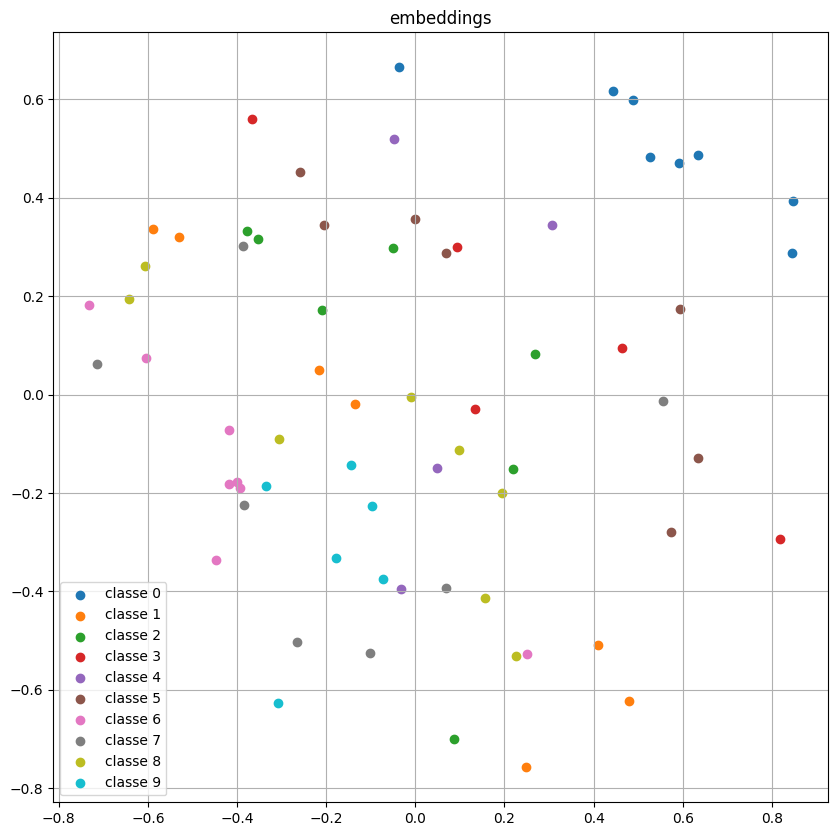

In [38]:
autoencoder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        emb, output = autoencoder(images)

        for i in range(emb.size(0)):
            embeddings.append([emb[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

#### Decoder

#### Sur jeu d'entrainement

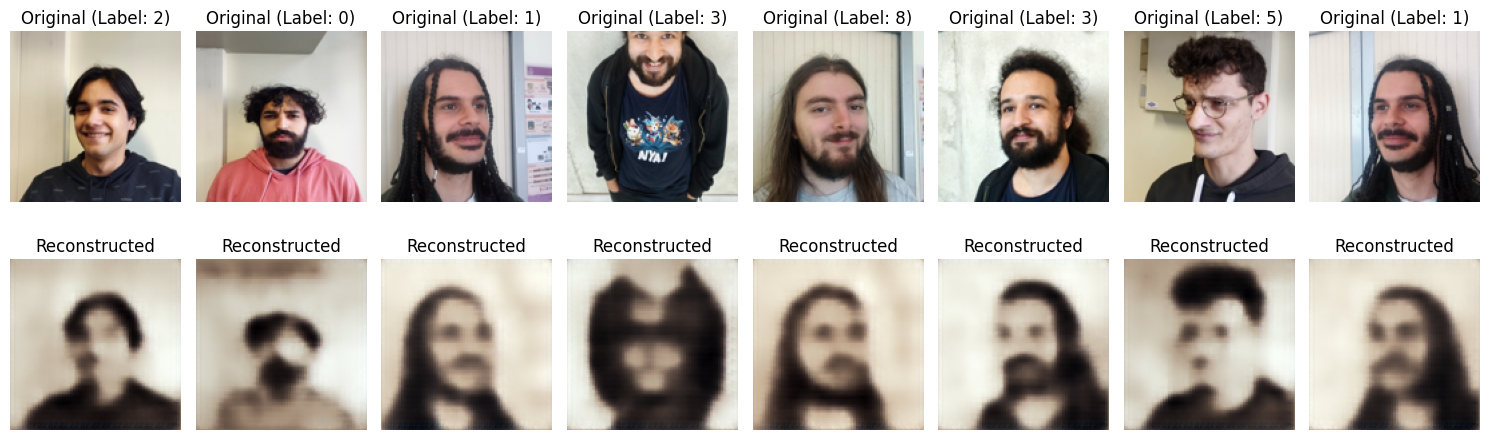

In [39]:
autoencoder.eval()
faceEmbedder.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    #embeddings = faceEmbedder(images)

    _,reconstructed_images = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

#### Sur jeu de test

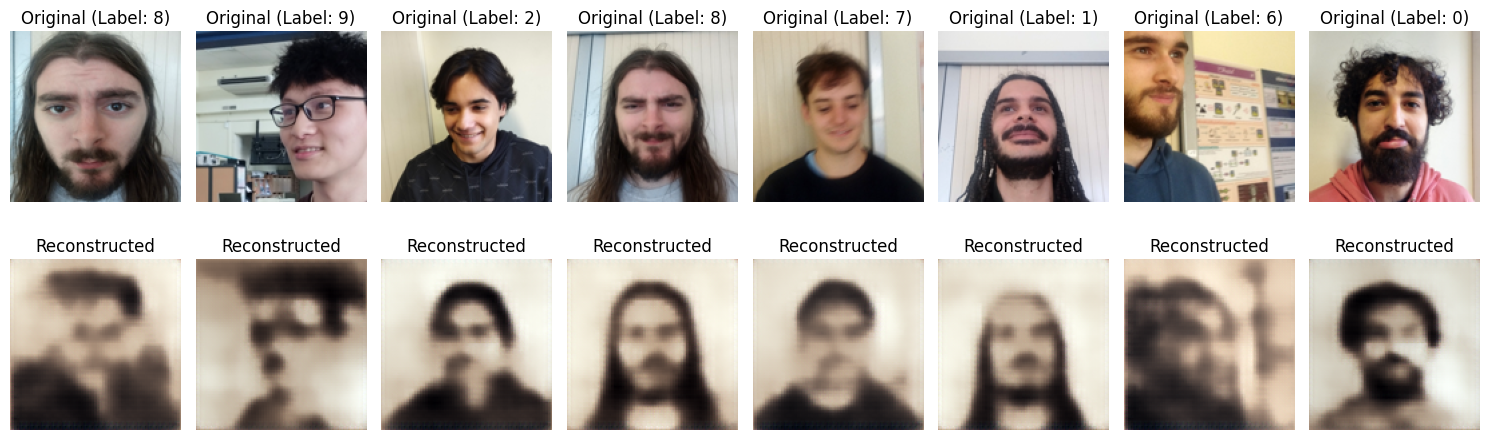

In [40]:
autoencoder.eval()
faceEmbedder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    #embeddings = faceEmbedder(images)

    _,reconstructed_images = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

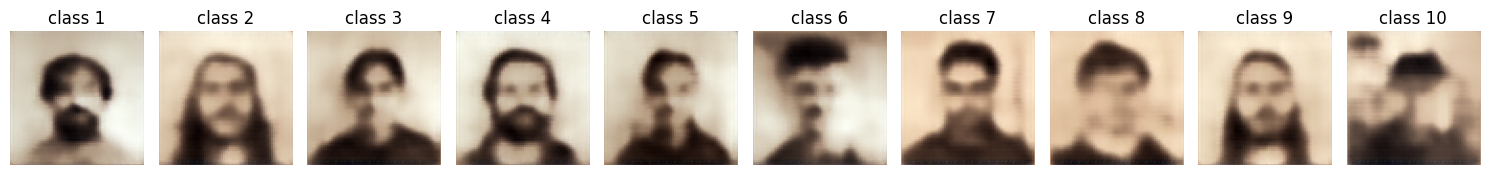

In [41]:
autoencoder.eval()

random_embeddings = torch.tensor(avg_embeddings, device=device, dtype=torch.float32)

random_embeddings = random_embeddings.to(device)

decoder_only = autoencoder.decoder.eval()

with torch.no_grad():
    generated_images = decoder_only(random_embeddings)

n = generated_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[i].imshow(img_disp)
    axs[i].axis("off")
    axs[i].set_title(f"class {i+1}")

plt.tight_layout()
plt.show()

##     Entrainement du decodeur uniquement avec un embedder deja entraine

In [ ]:
decoder = Decoder().to(device)
L1loss = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(100):
    total_loss = 0.0
    decoder.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)
        #print(images.size())

        output = decoder(embeded)
        #print(output.size())

        loss = L1loss(output, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    decoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = decoder(embeded)
        loss = L1loss(output, images)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



Epoch 1, training loss: 0.1856, test loss: 0.1848
Epoch 2, training loss: 0.1823, test loss: 0.1844
Epoch 3, training loss: 0.1837, test loss: 0.1840
Epoch 4, training loss: 0.1856, test loss: 0.1836
Epoch 5, training loss: 0.1817, test loss: 0.1832
Epoch 6, training loss: 0.1847, test loss: 0.1828
Epoch 7, training loss: 0.1773, test loss: 0.1823
Epoch 8, training loss: 0.1851, test loss: 0.1817
Epoch 9, training loss: 0.1807, test loss: 0.1809
Epoch 10, training loss: 0.1771, test loss: 0.1799
Epoch 11, training loss: 0.1719, test loss: 0.1785
Epoch 12, training loss: 0.1817, test loss: 0.1766
Epoch 13, training loss: 0.1758, test loss: 0.1742
Epoch 14, training loss: 0.1678, test loss: 0.1717
Epoch 15, training loss: 0.1685, test loss: 0.1700
Epoch 16, training loss: 0.1689, test loss: 0.1696
Epoch 17, training loss: 0.1670, test loss: 0.1681
Epoch 18, training loss: 0.1648, test loss: 0.1662
Epoch 19, training loss: 0.1580, test loss: 0.1647
Epoch 20, training loss: 0.1584, test lo

### Analyse

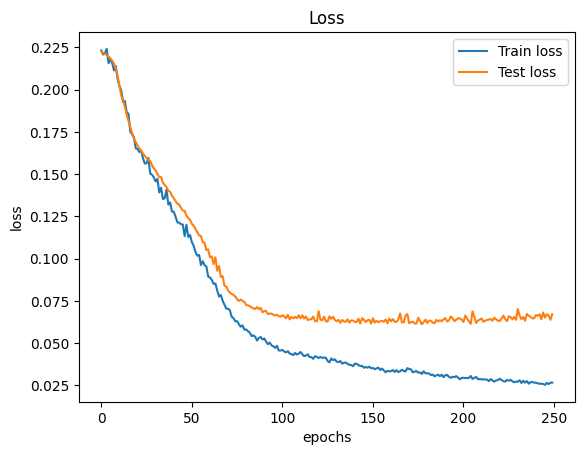

In [28]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

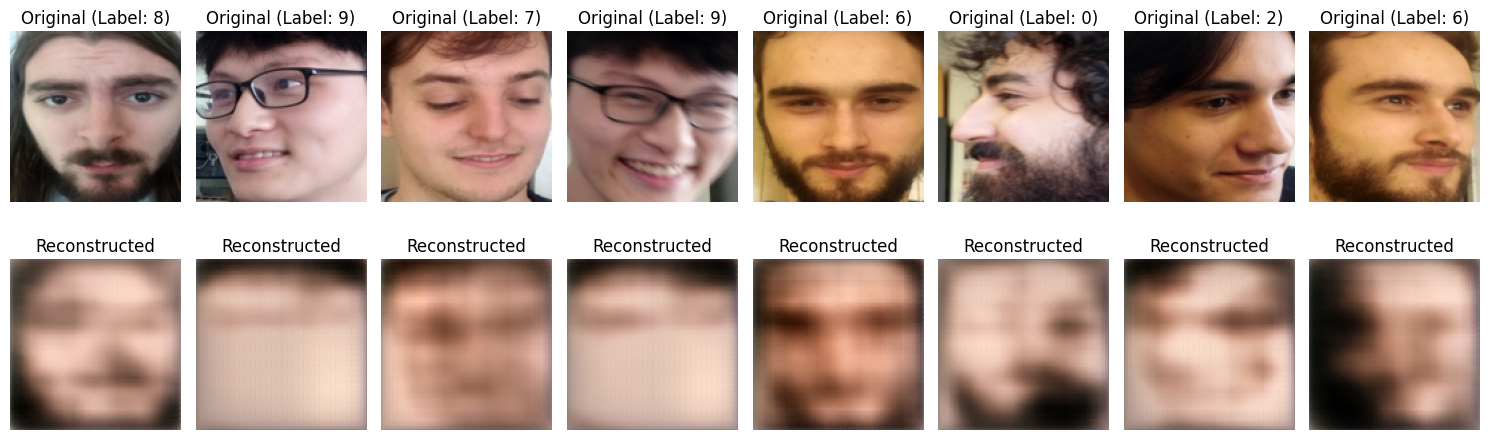

In [43]:
decoder.eval()
faceEmbedder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    embeddings = faceEmbedder(images)

    reconstructed_images = decoder(embeddings)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

### Reconstruction de la moyenne des embeddings de chaque classe

C:\Users\Arthur\AppData\Local\Temp\ipykernel_14168\525747257.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_embeddings = torch.tensor(avg_embeddings, device=device)  # Convert avg_embeddings to a PyTorch tensor


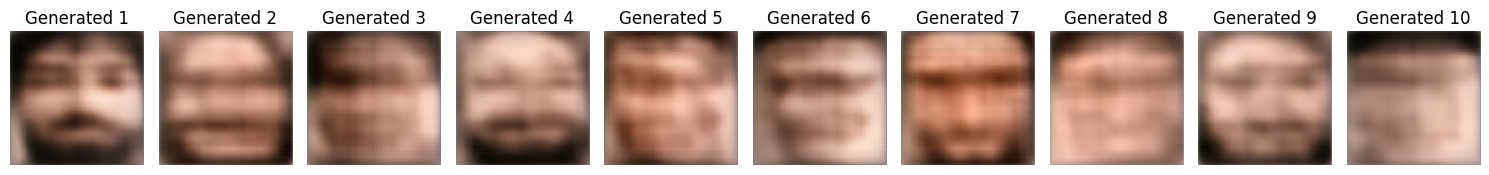

In [ ]:
decoder.eval()

random_embeddings = torch.tensor(avg_embeddings, device=device)

random_embeddings = random_embeddings.to(device)

with torch.no_grad():
    generated_images = decoder(random_embeddings)

n = generated_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[i].imshow(img_disp)
    axs[i].axis("off")
    axs[i].set_title(f"Generated {i+1}")

plt.tight_layout()
plt.show()